# Forest biomass model

Reference: [Grant B. Gustafson and Calvin H. Wilcox, *Analytical and Computational Methods of Advanced Engineering Mathematics*, Spriner (1998)](https://doi.org10.1007%2F978-1-4612-0633-0)  
We use a simple model of the forest biomass where $x(t)$ is the biomass decayed in humus, $y(t)$ the biomass of dead trees, and $z(t)$ the biomass of living trees.
We want to solve the system
\begin{align}
x' &= - x + 3y, \\
y' &= - 3y + 5z, \\
z' &= - 5z.
\end{align}
The eigenvalues are $-1$, $-3$, and $-5$. The change of coordinate matrix made of the eigenvectors is
\begin{equation}
P = \begin{pmatrix} 1 & 3 & 15 \\ 0 & 2 & -20 \\ 0 & 0 & 8 \end{pmatrix},
\end{equation}
which inverse reads
\begin{equation}
P^{-1} = \begin{pmatrix} 1 & -\frac32 & -\frac{45}8 \\ 0 & \frac12 & \frac54 \\ 0 & 0 & \frac18 \end{pmatrix}.
\end{equation}
Therefore
\begin{equation}
\exp(tA) 
= P \begin{pmatrix} e^{-t} & 0 & 0 \\ 0 & e^{-3t} & 0 \\ 0 & 0 & e^{-5t} \end{pmatrix} P^{-1}
= \begin{pmatrix} e^{-t} & \frac32e^{-t}-\frac32e^{-3t} & \frac{15}8e^{-t}-\frac{15}4e^{-3t}+\frac{15}8e^{-5t} \\ 0 & e^{-3t} & \frac52e^{-3t}-\frac52e^{-5t} \\ 0 & 0 & e^{-5t} \end{pmatrix}.
\end{equation}
We will take $(0,0,1)$ as initial data (only living trees).

## Exact solution

In [1]:
%matplotlib inline
from math import exp
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

In [2]:
def exact(T):
    exp1 = np.exp(-T)
    exp3 = np.exp(-3*T)
    exp5 = np.exp(-5*T)
    X = 1.875 * exp1 - 3.75 * exp3 + 1.875 * exp5
    Y = 2.5 * exp3 - 2.5 * exp5
    Z = exp5
    return X, Y, Z

In [3]:
A = np.array([[-1, 3, 0], [0, -3, 5],[0, 0, -5]])
vp, P = np.linalg.eig(A)
print(P)
invP = np.linalg.inv(P)
print(invP)
print(np.linalg.inv(A))

[[ 1.         -0.83205029  0.57145449]
 [ 0.          0.5547002  -0.76193932]
 [ 0.          0.          0.30477573]]
[[1.         1.5        1.875     ]
 [0.         1.80277564 4.50693909]
 [0.         0.         3.28110119]]
[[-1.         -1.         -1.        ]
 [-0.         -0.33333333 -0.33333333]
 [-0.         -0.         -0.2       ]]


## Data for tests

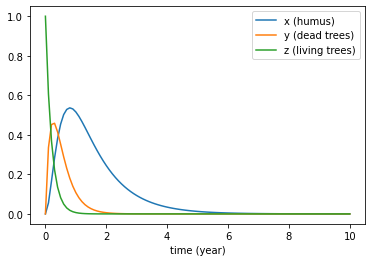

In [4]:
Tmax = 10
dt = .1
n = int(Tmax / dt)
T = dt * np.array(range(n+1))
XYZExact = exact(T)

plt.plot(T, XYZExact[0], label="x (humus)")
plt.plot(T, XYZExact[1], label="y (dead trees)")
plt.plot(T, XYZExact[2], label="z (living trees)")
plt.legend()
plt.xlabel('time (year)')
plt.savefig('Plots/Biomass_exact.png', format='png')
plt.savefig('Plots/Biomass_exact.pdf', format='pdf')

## Explicit Euler

\begin{align}
x_{k+1} &= (1 - \Delta t) x_k + 3\Delta t y_k, \\
y_{k+1} &= (1 - 3\Delta t) y_k + 5\Delta t z_k, \\
z_{k+1} &= (1 - 5\Delta t) z_k.
\end{align}

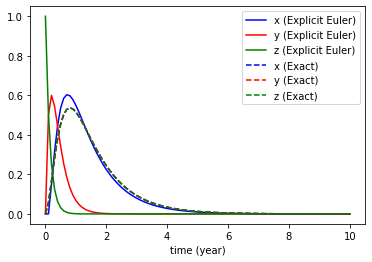

In [5]:
def xyz_explicit_Euler(dt, Tmax):
    n = int(Tmax / dt)
    T = dt * np.array(range(n+1))
    X = np.zeros(n+1,)
    Y = np.zeros(n+1,)
    Z = np.zeros(n+1,)
    Z[0] = 1
    for i in range(n):
        Z[i+1] = (1 - 5 * dt) * Z[i]
        Y[i+1] = (1 - 3 * dt) * Y[i] + 5 * dt * Z[i]
        X[i+1] = (1 - dt) * X[i] + 3 * dt * Y[i]
    return X, Y, Z
        
XYZEulerE = xyz_explicit_Euler(dt, Tmax)
plt.plot(T, XYZEulerE[0] ,'b', label="x (Explicit Euler)")
plt.plot(T, XYZEulerE[1] ,'r', label="y (Explicit Euler)")
plt.plot(T, XYZEulerE[2] ,'g', label="z (Explicit Euler)")
plt.plot(T, XYZExact[0] ,'--b', label="x (Exact)")
plt.plot(T, XYZExact[0] ,'--r', label="y (Exact)")
plt.plot(T, XYZExact[0] ,'--g', label="z (Exact)")
plt.xlabel("time (year)")
plt.legend();

## Implicit Euler

\begin{align}
x_{k+1} &= \frac1{1 + \Delta t} (x_k + 3\Delta t y_{k+1}), \\
y_{k+1} &= \frac1{1 + 3\Delta t} (y_k + 5\Delta t z_{k+1}), \\
z_{k+1} &= \frac1{1 + 5\Delta t} z_k.
\end{align}

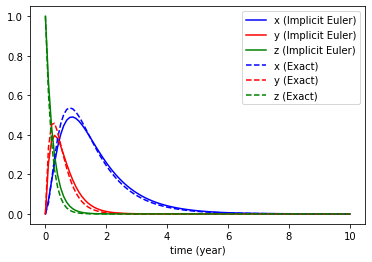

In [6]:
def xyz_implicit_Euler(dt, Tmax):
    n = int(Tmax / dt)
    T = dt * np.array(range(n+1))
    X = np.zeros(n+1,)
    Y = np.zeros(n+1,)
    Z = np.zeros(n+1,)
    Z[0] = 1
    for i in range(n):        
        Z[i+1] = Z[i] / (1 + 5 * dt)
        Y[i+1] = (Y[i] + 5 * dt * Z[i+1]) / (1 + 3 * dt)
        X[i+1] = (X[i] + 3 * dt * Y[i+1]) / (1 + dt)
    return X, Y, Z
        
XYZEulerI = xyz_implicit_Euler(dt, Tmax)
plt.plot(T, XYZEulerI[0] ,'b', label="x (Implicit Euler)")
plt.plot(T, XYZEulerI[1] ,'r', label="y (Implicit Euler)")
plt.plot(T, XYZEulerI[2] ,'g', label="z (Implicit Euler)")
plt.plot(T, XYZExact[0] ,'--b', label="x (Exact)")
plt.plot(T, XYZExact[1] ,'--r', label="y (Exact)")
plt.plot(T, XYZExact[2] ,'--g', label="z (Exact)")
plt.xlabel("time (year)")
plt.legend();

## Our scheme

\begin{align}
\alpha_0(\Delta t) & = \frac{15}8 e^{-\Delta t} - \frac54 e^{-3\Delta t} + \frac38 e^{-5\Delta t},\\
\alpha_1(\Delta t) & = e^{-\Delta t} - \frac32 e^{-3\Delta t} + \frac12 e^{-5\Delta t},\\
\alpha_2(\Delta t) & = \frac18 e^{-\Delta t} - \frac14 e^{-3\Delta t} + \frac18 e^{-5\Delta t}.
\end{align}
\begin{align}
X_{k+1} = \alpha_0(\Delta t) X_k + \alpha_1(\Delta t) A X_k + \alpha_2(\Delta t) A^2 X_k.
\end{align}
\begin{align}
x_{k+1} = \alpha_0(\Delta t) \begin{pmatrix} x_k \\ y_k \\ z_k \end{pmatrix} 
+ \alpha_1(\Delta t) \begin{pmatrix} - x_k + 3 y_k \\ -3 y_k + 5 z_k \\ - 5 z_k \end{pmatrix} 
+ \alpha_2(\Delta t) \begin{pmatrix} x_k - 12 y_k + 15 z_k \\ 9 y_k - 40 z_k \\ 25 z_k \end{pmatrix}
\end{align}

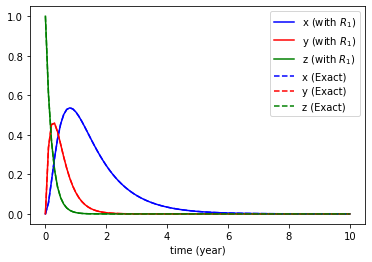

In [7]:
def xyz_NSFD(dt, Tmax):
    n = int(Tmax / dt)
    T = dt * np.array(range(n+1))
    exp1 = exp(-dt)
    exp3 = exp(-3*dt)
    exp5 = exp(-5*dt)
    alpha0 = 1.875 * exp1 - 1.25 * exp3 + 0.375 * exp5
    alpha1 = exp1 - 1.5 * exp3 + .5 * exp5
    alpha2 = .125  * exp1 - .25 * exp3 + .125 * exp5
    X = np.zeros(n+1,)
    Y = np.zeros(n+1,)
    Z = np.zeros(n+1,)
    Z[0] = 1
    for i in range(n):  
        Z[i+1] = (alpha0 - 5*alpha1 + 25*alpha2) * Z[i] 
        Y[i+1] = (alpha0 - 3*alpha1 + 9*alpha2) * Y[i] + (5*alpha1 - 40*alpha2) * Z[i] 
        X[i+1] = (alpha0 - alpha1 + alpha2) * X[i] \
        + (3*alpha1 - 12*alpha2) * Y[i] + 15*alpha2 * Z[i]
    return X, Y, Z
        
XYZNSFD = xyz_NSFD(dt, Tmax)
plt.plot(T, XYZNSFD[0] ,'b', label="x (with $R_1$)")
plt.plot(T, XYZNSFD[1] ,'r', label="y (with $R_1$)")
plt.plot(T, XYZNSFD[2] ,'g', label="z (with $R_1$)")
plt.plot(T, XYZExact[0] ,'--b', label="x (Exact)")
plt.plot(T, XYZExact[1] ,'--r', label="y (Exact)")
plt.plot(T, XYZExact[2] ,'--g', label="z (Exact)")
plt.xlabel("time (year)")
plt.legend();

Let us replace the $\alpha_j$ by their order 3 approximation.
\begin{align}
\alpha_0(\Delta t) & = \frac{15}8 e^{-\Delta t} - \frac54 e^{-3\Delta t} + \frac38 e^{-5\Delta t} \simeq \beta_0(\Delta t) = 1 - \frac52\Delta t^3,\\
\alpha_1(\Delta t) & = e^{-\Delta t} - \frac32 e^{-3\Delta t} + \frac12 e^{-5\Delta t} \simeq \beta_1(\Delta t) = \Delta t - \frac{23}6 \Delta t^3,\\
\alpha_2(\Delta t) & = \frac18 e^{-\Delta t} - \frac14 e^{-3\Delta t} + \frac18 e^{-5\Delta t} \simeq \beta_2(\Delta t) = \frac12\Delta t^2 - \frac32 \Delta t^3.
\end{align}

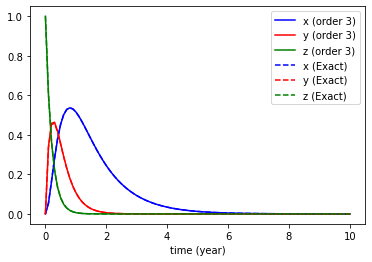

In [8]:
def xyz_NSFD2(dt, Tmax):
    n = int(Tmax / dt)
    T = dt * np.array(range(n+1))
    beta0 = 1 - 2.5 * dt * dt * dt
    beta1 = dt - 23/6 * dt * dt * dt
    beta2 = .5 * dt * dt - 1.5 * dt *dt * dt
    X = np.zeros(n+1,)
    Y = np.zeros(n+1,)
    Z = np.zeros(n+1,)
    Z[0] = 1
    for i in range(n):  
        Z[i+1] = (beta0 - 5*beta1 + 25*beta2) * Z[i] 
        Y[i+1] = (beta0 - 3*beta1 + 9*beta2) * Y[i] + (5*beta1 - 40*beta2) * Z[i] 
        X[i+1] = (beta0 - beta1 + beta2) * X[i] \
        + (3*beta1 - 12*beta2) * Y[i] + 15 * beta2 * Z[i]
    return X, Y, Z
        
XYZNSFD2 = xyz_NSFD2(dt, Tmax)
plt.plot(T, XYZNSFD2[0] ,'b', label="x (order 3)")
plt.plot(T, XYZNSFD2[1] ,'r', label="y (order 3)")
plt.plot(T, XYZNSFD2[2] ,'g', label="z (order 3)")
plt.plot(T, XYZExact[0] ,'--b', label="x (Exact)")
plt.plot(T, XYZExact[1] ,'--r', label="y (Exact)")
plt.plot(T, XYZExact[2] ,'--g', label="z (Exact)")
plt.xlabel("time (year)")
plt.legend();

## Mickens' scheme

We apply the general procedure for each equation separately. This yields
\begin{align}
x_{k+1} &= e^{-\Delta t} x_k + (1-e^{-\Delta t}) 3 y_k, \\
y_{k+1} &= e^{-3\Delta t} y_k + \frac{1-e^{-3\Delta t}}3 5 z_k, \\
z_{k+1} &= e^{-5\Delta t} z_k.
\end{align}

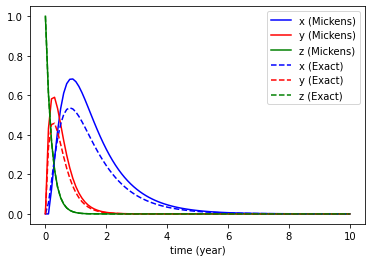

In [9]:
def xyz_Mickens(dt, Tmax):
    n = int(Tmax / dt)
    T = dt * np.array(range(n+1))
    dtx = 1-exp(-dt)
    dty = (1-exp(-3*dt))/3
    dtz = (1-exp(-5*dt))/5
    X = np.zeros(n+1,)
    Y = np.zeros(n+1,)
    Z = np.zeros(n+1,)
    Z[0] = 1
    for i in range(n):
        Z[i+1] = Z[i] + dtz * (-5 * Z[i])
        Y[i+1] = Y[i] + dty * (-3 * Y[i] + 5 * Z[i])
        X[i+1] = X[i] + dtx * (- X[i] + 3 * Y[i])
    return X, Y, Z
        
XYZMickens = xyz_Mickens(dt, Tmax)
plt.plot(T, XYZMickens[0] ,'b', label="x (Mickens)")
plt.plot(T, XYZMickens[1] ,'r', label="y (Mickens)")
plt.plot(T, XYZMickens[2] ,'g', label="z (Mickens)")
plt.plot(T, XYZExact[0] ,'--b', label="x (Exact)")
plt.plot(T, XYZExact[1] ,'--r', label="y (Exact)")
plt.plot(T, XYZExact[2] ,'--g', label="z (Exact)")
plt.xlabel("time (year)")
plt.legend();

## Error analysis

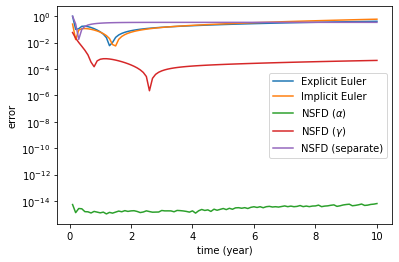

In [10]:
ErrorEulerE = np.array([abs((x - xe) / xe) \
                        for x, xe in zip(XYZEulerE[0][1:], XYZExact[0][1:])])
ErrorEulerI = np.array([abs((x - xe) / xe) \
                        for x, xe in zip(XYZEulerI[0][1:], XYZExact[0][1:])])
ErrorNSFD = np.array([abs((x - xe) / xe) \
                      for x, xe in zip(XYZNSFD[0][1:], XYZExact[0][1:])])
ErrorNSFD2 = np.array([abs((x - xe) / xe) \
                       for x, xe in zip(XYZNSFD2[0][1:], XYZExact[0][1:])])
ErrorMickens= np.array([abs((x - xe) / xe) \
                        for x, xe in zip(XYZMickens[0][1:], XYZExact[0][1:])])

plt.semilogy(T[1:], ErrorEulerE, label="Explicit Euler")
plt.semilogy(T[1:], ErrorEulerI, label="Implicit Euler")
plt.semilogy(T[1:], ErrorNSFD, label=r"NSFD ($\alpha$)")
plt.semilogy(T[1:], ErrorNSFD2, label=r"NSFD ($\gamma$)")
plt.semilogy(T[1:], ErrorMickens, label="NSFD (separate)")
plt.xlabel("time (year)")
plt.ylabel('error')
plt.legend(loc='right');

In [11]:
I = np.eye(3,3)
A = np.array([[-1, 3, 0], [0, -3, 5],[0, 0, -5]])
A2 = A @ A
exp1 = exp(-dt)
exp2 = exp(-2*dt)
exp3 = exp(-3*dt)
exp5 = exp(-5*dt)
expdtA = np.array([[exp1, 1.5 * exp1 - 1.5 * exp3, 1.875 * exp1 - 3.75 * exp3 + 1.875 * exp5],
                 [0, exp3, 2.5 * exp3 - 2.5 * exp5], [0, 0, exp5]])
print(expdtA)
alpha0 = 1.875 * exp1 - 1.25 * exp3 + 0.375 * exp5
alpha1 = exp1 - 1.5 * exp3 + .5 * exp5
alpha2 = .125  * exp1 - .25 * exp3 + .125 * exp5
expdtAbis = alpha0 * I + alpha1 * A + alpha2 * A2
print(expdtAbis)
beta0 = 1 - 2.5 * dt * dt * dt
beta1 = dt - 23/6 * dt * dt * dt
beta2 = .5 * dt * dt - 1.5 * dt *dt * dt
expdtAter = beta0 * I + beta1 * A + beta2 * A2
print(expdtAter)

[[0.90483742 0.2460288  0.05574682]
 [0.         0.74081822 0.3357189 ]
 [0.         0.         0.60653066]]
[[0.90483742 0.2460288  0.05574682]
 [0.         0.74081822 0.3357189 ]
 [0.         0.         0.60653066]]
[[0.90483333 0.2465     0.0525    ]
 [0.         0.7405     0.34083333]
 [0.         0.         0.60416667]]


## Order analysis

In [12]:
def Error(XYZ, dt, norm):
    XError = np.linalg.norm(XYZ[0] - XYZExact[0], ord=norm)
    YError = np.linalg.norm(XYZ[1] - XYZExact[1], ord=norm)
    ZError = np.linalg.norm(XYZ[2] - XYZExact[2], ord=norm)
    return dt*XError + dt*YError + dt*ZError

[[2.38311535e-01 1.84970278e-01 2.06722307e-15 5.93625327e-03
  3.85979264e-01]
 [1.10825872e-01 9.78746743e-02 1.31745568e-15 6.08516712e-04
  1.82548934e-01]
 [2.10442857e-02 2.05322499e-02 1.62877655e-14 4.10883872e-06
  3.48577208e-02]
 [2.08105579e-03 2.07592928e-03 9.28838547e-14 3.95092860e-09
  3.44944085e-03]
 [1.03988569e-03 1.03860425e-03 2.25384443e-13 4.92772479e-10
  1.72371414e-03]]


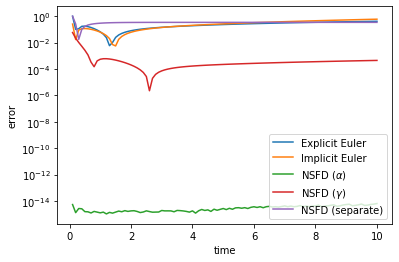

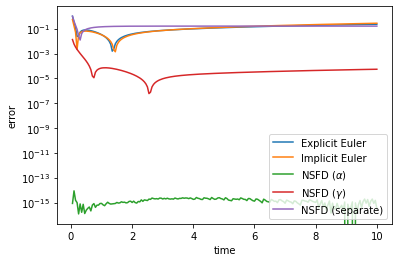

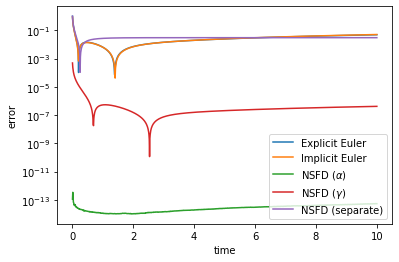

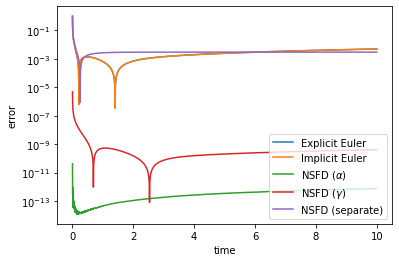

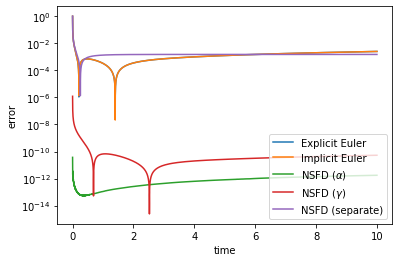

In [13]:
dt_tab = [0.1, 0.05, 0.01, 0.001, 0.0005]
errors = np.zeros((len(dt_tab), 5))
for (j, dt) in enumerate(dt_tab):
    n = int(Tmax/dt)
    T = dt*np.array(range(n+1))
    XYZExact = exact(T)
    XYZEulerE = xyz_explicit_Euler(dt, Tmax)
    XYZEulerI = xyz_implicit_Euler(dt, Tmax)
    XYZNSFD = xyz_NSFD(dt, Tmax)
    XYZNSFD2 = xyz_NSFD2(dt, Tmax)
    XYZMickens = xyz_Mickens(dt, Tmax)
    # Errors
    errors[j,0] = Error(XYZEulerE, dt, 1)
    errors[j,1] = Error(XYZEulerI, dt, 1)
    errors[j,2] = Error(XYZNSFD, dt, 1)
    errors[j,3] = Error(XYZNSFD2, dt, 1)
    errors[j,4] = Error(XYZMickens, dt, 1)
    # Plots
    plt.figure(j)
    ErrorEulerE = np.array([abs((x - xe) / xe) \
                for x, xe in zip(XYZEulerE[0][1:], XYZExact[0][1:])])
    ErrorEulerI = np.array([abs((x - xe) / xe) \
                for x, xe in zip(XYZEulerI[0][1:], XYZExact[0][1:])])
    ErrorNSFD = np.array([abs((x - xe) / xe) \
              for x, xe in zip(XYZNSFD[0][1:], XYZExact[0][1:])])
    ErrorNSFD2 = np.array([abs((x - xe) / xe) \
               for x, xe in zip(XYZNSFD2[0][1:], XYZExact[0][1:])])
    ErrorMickens = np.array([abs((x - xe) / xe) \
                 for x, xe in zip(XYZMickens[0][1:], XYZExact[0][1:])])
    plt.semilogy(T[1:], ErrorEulerE, label="Explicit Euler")
    plt.semilogy(T[1:], ErrorEulerI, label="Implicit Euler")
    plt.semilogy(T[1:], ErrorNSFD, label=r"NSFD ($\alpha$)")
    plt.semilogy(T[1:], ErrorNSFD2, label=r"NSFD ($\gamma$)")
    plt.semilogy(T[1:], ErrorMickens, label="NSFD (separate)")
    plt.xlabel('time')
    plt.ylabel('error')
    plt.legend(loc='lower right')
    plt.savefig('Plots/Biomass_'+str(dt_tab[j])[2:]+'.png', format='png')
    plt.savefig('Plots/Biomass_'+str(dt_tab[j])[2:]+'.pdf', format='pdf')
print(errors)

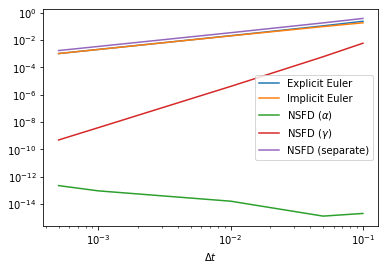

In [14]:
methods_tab = ['Explicit Euler', 'Implicit Euler',
               r'NSFD ($\alpha$)', r'NSFD ($\gamma$)', 
               'NSFD (separate)']

plt.loglog(dt_tab,errors)
plt.xlabel('$\Delta t$')
plt.legend(methods_tab)
plt.savefig('Plots/Biomass_orders.png', format='png')
plt.savefig('Plots/Biomass_orders.pdf', format='pdf')

In [15]:
orders = [linregress(np.log(dt_tab),np.log(errors[:,k])).slope 
          for k in range(len(methods_tab))]
for (method,order) in zip(methods_tab,orders):
    print(method, ':', order)

Explicit Euler : 1.0217317874843412
Implicit Euler : 0.9810307602885683
NSFD ($\alpha$) : -0.9519906983295395
NSFD ($\gamma$) : 3.067071027600866
NSFD (separate) : 1.0184355212954581
